In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
stimuli = np.random.randn(10,2)

[]

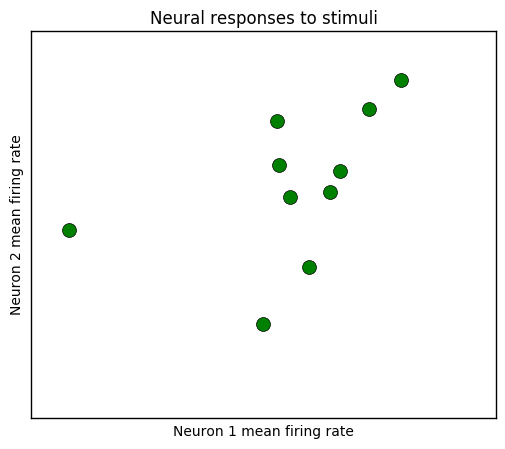

In [3]:
plt.figure(figsize=(6,5))
plt.plot(stimuli[:,0], stimuli[:,1], linestyle='', c='g', marker='o', markersize=10)
plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])
plt.title('Neural responses to stimuli')
plt.xlabel('Neuron 1 mean firing rate')
plt.ylabel('Neuron 2 mean firing rate')
frame = plt.gca()
frame.axes.get_xaxis().set_ticks([])
frame.axes.get_yaxis().set_ticks([])

In [4]:
def confusionRate( p1, p2 ):
    o1 = np.tanh(p1*1 + .5) + np.random.randn()*.001
    o2 = np.tanh(p2*1 + .5) + np.random.randn()*.001
    return min( np.linalg.norm(o1 - o2)/2, 1 )
    

m = len(stimuli)
C = np.zeros((m,m))
for i in range(m):
    for j in range(m):
        if (i != j):
            C[i,j] = confusionRate( stimuli[i,:], stimuli[j,:] )
        

[]

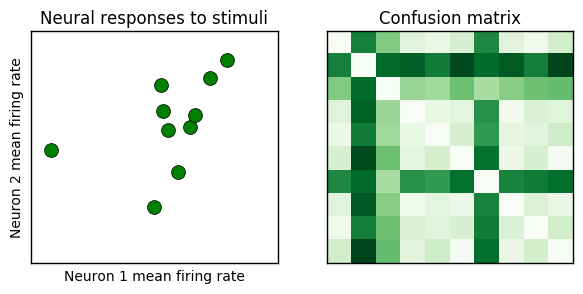

In [5]:
plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plt.plot(stimuli[:,0], stimuli[:,1], linestyle='', c='g', marker='o', markersize=10)
plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])
plt.title('Neural responses to stimuli')
plt.xlabel('Neuron 1 mean firing rate')
plt.ylabel('Neuron 2 mean firing rate')
frame = plt.gca()
frame.axes.get_xaxis().set_ticks([])
frame.axes.get_yaxis().set_ticks([])
plt.subplot(1,2,2)
heatmap = plt.pcolor(C, cmap=matplotlib.cm.Greens)
plt.title("Confusion matrix")
plt.gca().invert_yaxis()
frame = plt.gca()
frame.axes.get_xaxis().set_ticks([])
frame.axes.get_yaxis().set_ticks([])

In [15]:
def tanh(x, y, a=1, b=0):
    return np.tanh( a * np.dot(x.T, y) + b)

def dxTanh(x, a=1, b=0):
    return 2*a*x - 2*a*x*np.tanh(a*np.linalg.norm(x)**2 + b )**2

def phi(x, X, K=tanh, a=1, b=0):
    phi_x = []
    for xi in X:
        phi_x.append(K(x, xi))
    return np.matrix(phi_x)

def generatePhis(X, K=tanh, a=1, b=1):
    phis = []
    for x in X:
        phis.append(phi(x, X, K, a, b))
    return phis

def loss(X, w, D, phis, K=tanh, reg=.5, a=1, b=0):
    m = len(X)
    L = 0
    for i in range(m):
        for j in range(m):
            d = np.dot(w, (phis[i].T - phis[j].T) )
            L += (1.0/m**2)*.5* (tanh(d, d, a, b) - D[i,j])[0,0]**2 + .5*reg*np.linalg.norm(w)**2
    return L

def lossNoPhi(X, w, D, K=tanh, reg=.5, a=1, b=0):
    phis = generatePhis(X, K, a, b)
    return loss(X, w, D, phis, K, reg, a, b)

def calcGrad(X, w, D, phis, K=tanh, reg=.5, a=1, b=0):
    m = len(X)
    dldw = np.zeros(np.shape(w))
    for i in range(m):
        for j in range(m):
            d = np.dot(w, (phis[i].T - phis[j].T))
            dldw += (tanh(d, d, a, b) - D[i,j])[0,0]*np.dot(dxTanh(d,a,b),(phis[i]-phis[j])) + 2*reg*w
    return dldw

def calcDistances(X, w, K=tanh, a=1, b=0):
    phis = generatePhis(X, K, a, b)
    m = len(X)
    D = np.ones((m,m))
    for i in range(m):
        for j in range(m):
            if (not i==j):
                D[i,j] = K(phis[i].T,phis[j].T,a,b)
    return D

def generateCMFigure(orig_D, learned_D, t1="Original confusion matrix", t2="Learned confusion matrix"):
    plt.figure(figsize=(7,3))
    plt.subplot(1,2,1)
    heatmap1 = plt.pcolor(1-orig_D, cmap=matplotlib.cm.Greens)
    plt.title(t1)
    plt.gca().invert_yaxis()
    frame = plt.gca()
    frame.axes.get_xaxis().set_ticks([])
    frame.axes.get_yaxis().set_ticks([])
    plt.subplot(1,2,2)
    heatmap2 = plt.pcolor(1-learned_D, cmap=matplotlib.cm.Greens)
    plt.title(t2)
    plt.gca().invert_yaxis()
    frame = plt.gca()
    frame.axes.get_xaxis().set_ticks([])
    frame.axes.get_yaxis().set_ticks([])

def optimizeGradientDescent(X, D, outdim=-1, reg=.5, lr=-1, max_iter=1e6, threshold=1e-20, K=tanh, a=1, b=0):
    if (lr==-1):
        lr = 1e-6
    if (outdim==-1):
        outdim = np.shape(X)[1]
    m = len(X)
    w = np.random.randn(outdim, m)
    phis= generatePhis(X, K, a, b)
    i = 0
    epsilon=-1
    last_loss = 1e10
    while ( epsilon==-1 or (epsilon>threshold and i<max_iter)):
        w = w - lr*calcGrad(X, w, D, phis, K, reg, a, b)
        L = loss(X, w, D, phis, K, reg, a, b)
        epsilon = np.abs(L - last_loss)
        last_loss = L
        i+=1
        
    learned_D = calcDistances(X, w, K, a, b)
    print("Number of iterations: %d")%i
    print("Final loss: %f")%((1.0/m**2)*np.sum(np.sum(np.power(learned_D - D, 2))))
    generateCMFigure(D, learned_D)
    return w,D

Number of iterations: 1000
Final loss: 0.028268


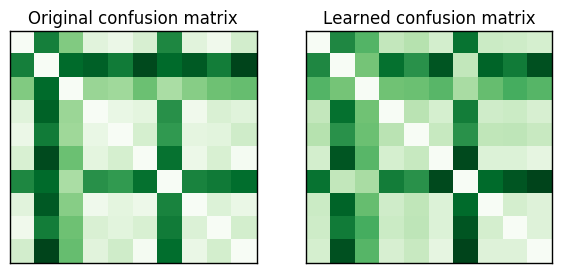

In [16]:
D = 1-C
A=.1
B=.5
w,learned_D = optimizeGradientDescent(stimuli, D, threshold=1e-7, reg=.01, lr=.001, max_iter=1000, a=A, b=B)

In [17]:
phis = generatePhis(stimuli)
y = []
for p in phis:
    y.append(np.dot(w, p.T))
y = np.array(y)

[]

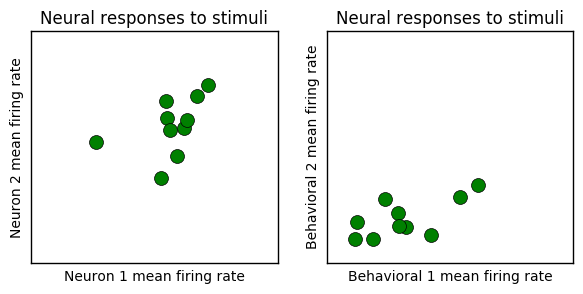

In [18]:
plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plt.plot(stimuli[:,0], stimuli[:,1], linestyle='', c='g', marker='o', markersize=10)
plt.xlim([min(min(stimuli[:,0])*2, min(stimuli[:,1])), max(max(stimuli[:,0]),max(stimuli[:,1]))*2])
plt.ylim([min(min(stimuli[:,0])*2, min(stimuli[:,1])), max(max(stimuli[:,0]),max(stimuli[:,1]))*2])
plt.title('Neural responses to stimuli')
plt.xlabel('Neuron 1 mean firing rate')
plt.ylabel('Neuron 2 mean firing rate')
frame = plt.gca()
frame.axes.get_xaxis().set_ticks([])
frame.axes.get_yaxis().set_ticks([])
plt.subplot(1,2,2)
plt.plot(y[:,0], y[:,1], linestyle='', c='g', marker='o', markersize=10)
plt.xlim([min(min(y[:,0])*2, min(y[:,1])), max(max(y[:,0]),max(y[:,1]))*2])
plt.ylim([min(min(y[:,0])*2, min(y[:,1])), max(max(y[:,0]),max(y[:,1]))*2])
plt.title('Neural responses to stimuli')
plt.xlabel('Behavioral 1 mean firing rate')
plt.ylabel('Behavioral 2 mean firing rate')
frame = plt.gca()
frame.axes.get_xaxis().set_ticks([])
frame.axes.get_yaxis().set_ticks([])

In [ ]:
test_stimuli = np.random.randn(10,2)

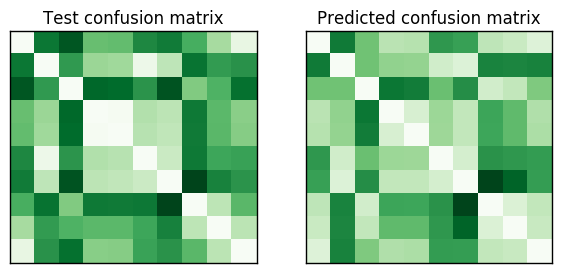

In [22]:

m = len(test_stimuli)
test_C = np.zeros((m,m))
for i in range(m):
    for j in range(m):
        if (i != j):
            test_C[i,j] = confusionRate( test_stimuli[i,:], test_stimuli[j,:] )

test_phis = generatePhis(test_stimuli, a=A, b=B)
test_y = []
for p in phis:
    test_y.append(np.dot(w, p.T))
test_y = np.array(test_y)

test_C_hat = calcDistances(test_stimuli, w, a=A, b=B)

generateCMFigure(1-test_C, test_C_hat, t1="Test confusion matrix", t2="Predicted confusion matrix")

[]

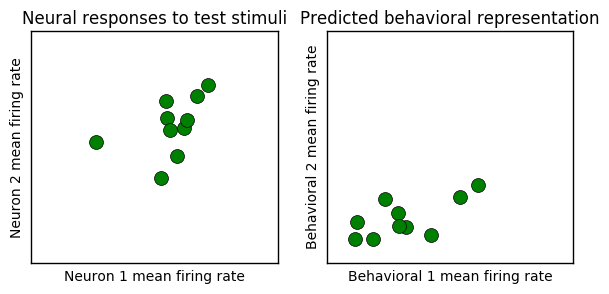

In [24]:
plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plt.plot(stimuli[:,0], stimuli[:,1], linestyle='', c='g', marker='o', markersize=10)
plt.xlim([min(min(stimuli[:,0])*2, min(stimuli[:,1])), max(max(stimuli[:,0]),max(stimuli[:,1]))*2])
plt.ylim([min(min(stimuli[:,0])*2, min(stimuli[:,1])), max(max(stimuli[:,0]),max(stimuli[:,1]))*2])
plt.title('Neural responses to test stimuli')
plt.xlabel('Neuron 1 mean firing rate')
plt.ylabel('Neuron 2 mean firing rate')
frame = plt.gca()
frame.axes.get_xaxis().set_ticks([])
frame.axes.get_yaxis().set_ticks([])
plt.subplot(1,2,2)
plt.plot(y[:,0], y[:,1], linestyle='', c='g', marker='o', markersize=10)
plt.xlim([min(min(y[:,0])*2, min(y[:,1])), max(max(y[:,0]),max(y[:,1]))*2])
plt.ylim([min(min(y[:,0])*2, min(y[:,1])), max(max(y[:,0]),max(y[:,1]))*2])
plt.title('Predicted behavioral representation')
plt.xlabel('Behavioral 1 mean firing rate')
plt.ylabel('Behavioral 2 mean firing rate')
frame = plt.gca()
frame.axes.get_xaxis().set_ticks([])
frame.axes.get_yaxis().set_ticks([])

In [37]:
M = np.linalg.norm(w)*np.sqrt(2)
(0.028268 + M * np.sqrt(2*np.log(1/.05)/30) + 2*(M**2)/30)

0.43323964071861998

In [35]:
((1.0/m**2)*np.sum(np.sum(np.power(test_C - test_C_hat, 2))))

0.38930854116053504